### Tanzinian Water Pump Classification ###

### Exploritory Data Analysis

This notebook will show how we determine which features to use. 
We will explore the relationships between the features and target data as well as a look at our feature engineering. 

In [478]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle 
import numpy as np
from scipy.stats import chi2_contingency

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None

from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes

In [479]:
df = pd.read_pickle('clean_df.pkl')

In [480]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,roman catholic church,1390,Roman,34.9381,-9.8563,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,grumeti,1399,GRUMETI,34.6988,-2.1475,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,lottery club,686,World vision,37.4607,-3.8213,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,unicef,263,UNICEF,38.4862,-11.1553,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,action in a,0,Artisan,31.1308,-1.8254,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Feature Managment 

We know that not all of these will be helpful features, and that is was EDA is all about. 
Let's take a look at the columns. 


We have a lot of columns to work through, so as we go through them, we will start a list of columns to drop. For example, 'id' is not a relevant predictor, so we will add it to the list. 
Additionally if we have the date_recorded, we already know if it is functional or needs repairs, so we will also drop that column. 

In [482]:
dropcols = ['id', 'date_recorded', 'recorded_by']

### dropcols

- ['id']
- ['date_recorded']
- ['recorded_by']
- ['wpt_name']
- ['source_type']
- ['source_class'] 
- ['waterpoint_type_group'] 
- ['payment']
- ['scheme_name']
- ['quantity_group']
- ['extraction_type_group'] 
- ['extraction_type_class']
- ['management_group']
- ['region_code']

### Continuous Features 

- ['amount_tsh']
- ['gps_height']
- ['longitude'] & ['latitude']
- ['population']
- ['construction_year']

### Catergorical Features

- ['funder']
- ['installer'] 
- ['quantity']
- ['quality_group'] 
- [ 'water_quality']
- ['payment_type']
- ['source']
- ['waterpoint_type']
- ['num_private']
- ['extraction_type']
- ['scheme_management'] 
- ['management'] 
- ['public_meeting']
- ['permit']

Location Based Engineering

- ['basin']
- ['region'] 
- ['district_code'] 
- ['lga'] (local goverment areas)
- ['ward']
- ['subvillage']

Target 
- ['status_group']

For catergorical features like we saw in the data cleaning of funder, we need to make sure they are all lowercase for better manipulation. 

In [203]:
text_feats = ['funder', 'installer', 'wpt_name', 'basin', 
 'subvillage', 'region', 'lga', 'ward',  
 'scheme_management', 'scheme_name', 'extraction_type',
 'extraction_type_group', 'extraction_type_class', 'management',
 'management_group', 'payment', 'payment_type', 'water_quality',
 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
 'source_class', 'waterpoint_type', 'waterpoint_type_group']

for c in text_feats:
    df[c] = [x.lower() for x in df[c]]

## Visualizations and Finding Relationships

Below we start with a look at the status_groups. This does show what we already know in that
the classes are imbalanced with functional needs repair as the smallest class. 

### Target
#### ['status_group']

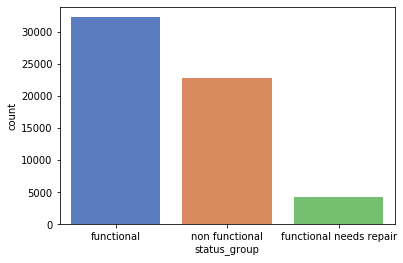

In [117]:
sns.countplot(df.status_group, palette = 'muted')
plt.show()

### Amount TSH - Continuous 
#### ['amount_tsh'] vs ['status_group']

In [118]:
#df[df['status_group'] == 'non functional']['amount_tsh'].value_counts()

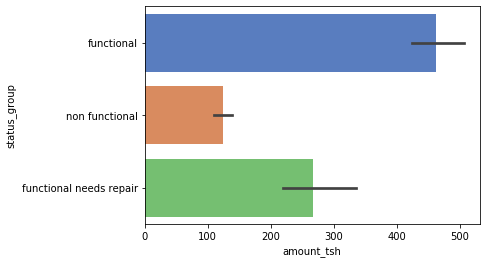

In [119]:
sns.barplot(x = 'amount_tsh', y = 'status_group', data = df, palette = 'muted')
plt.show()

### GPS Height - Continuous 
#### ['gps_height'] vs ['status_group'] 

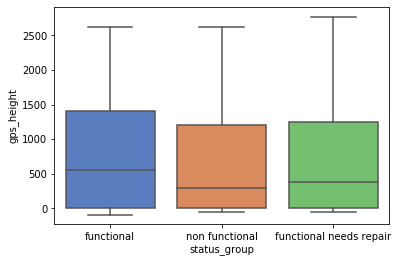

In [120]:
sns.boxplot(x = 'status_group', y = 'gps_height', data = df, palette = 'muted')
plt.show()

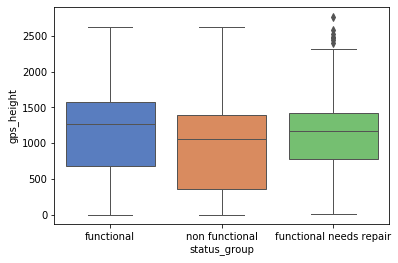

In [131]:
# took out zero values
sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df[df.gps_height > 0], linewidth = 1, palette = 'muted')
plt.show()

In [132]:
import scipy.stats as st
st.ttest_ind(df[(df.gps_height > 0) & (df.status_group == 'functional')].gps_height, 
             df[(df.gps_height > 0) & (df.status_group == 'non functional')].gps_height)

#Our independent t test does show there is statistical significance between functional and non-functional. 

Ttest_indResult(statistic=30.600722658837718, pvalue=5.754674377100651e-203)

### Funder and Installer
#### ['funder']/['installer'] vs ['status_group']

Looking at the funders and the installers of the wells, I imagined turning these into dummy variables would be helpful. 
However, given the number of these groups, we decided that funder/installer with 3 or more listings we could keep and turn into dummies. 



In [121]:
#list(df['funder'].sort_values(ascending = False).unique())

In [122]:
other_funders = df.funder.unique()[df.funder.value_counts() <= 3]
df['funder'] = np.where(df.funder.isin(other_funders), 'others', df.funder)

In [123]:
other_installer = df.installer.unique()[df.installer.value_counts() <= 3]
df['installer'] = np.where(df.installer.isin(other_installer), 'others', df.installer)

### Latitude and Longitude
#### ['latitude']/['longitude'] vs ['status_group']

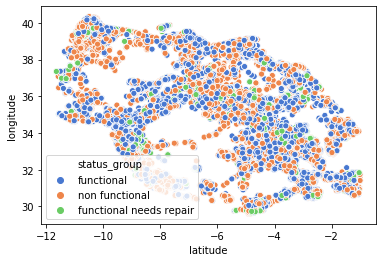

In [124]:
sns.scatterplot(x = 'latitude', y = 'longitude', data = df, hue = 'status_group', palette = 'muted');

In [ ]:
# Geo Pandas Here


### WPT Name / Num Private 
#### ['wpt_name']/['num_private'] vs ['status_group']

WPT is the "water point name", this should have no effect on the target itself and should be removed. 

In [125]:
dropcols = dropcols + ['wpt_name']

Num_Private I don't know exactly what this is but the overwhelming majority show 0. 
For now we have opted to leave this as is and see what we may want to do with it later. 

In [126]:
df['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

## Locations

### Basin / Subvillage / Region / Region Code / District Code / Ward 

#### ['basin']/['subvillage']/['region']/['region_code']/['district_code']/['ward']/['lga'] vs ['status_group']

We have a lot of location information. 
The basin is where the water is coming from. 
There are 31 regions of Tanzania were divided into 169 districts.
From there the districts are further divided into wards or county like areas.
Subvillages are the breakdown in neighborhoods. 

#### 31 Regions > 169 Districs (as of 2012) > Wards (counties) > Subvillages (smaller neighborhoods) 

#### Basin

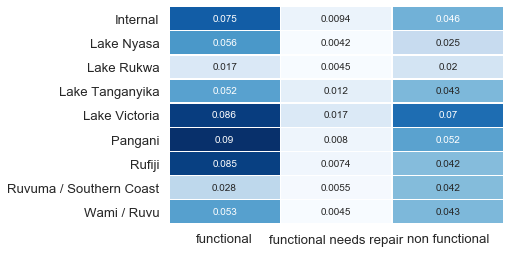

In [488]:
ct = pd.crosstab(df.basin, df.status_group,normalize = True)
sns.heatmap(ct, annot = True, linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

#### Region vs Region Code

Region has a few more values than region code. We opted to drop region code. 

In [ ]:
dropcols = dropcols + ['region_code']

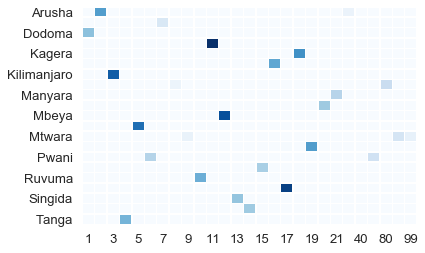

In [483]:
ct = pd.crosstab(df['region'], df['region_code'],normalize = True)
sns.heatmap(ct, linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [489]:
print(len(df.region.unique()))
print(len(df.region_code.unique()))

21
27


In [127]:
# convert region_code and district_code to be objects.
df['region_code'] = df.region_code.astype('object')
df['district_code'] = df.district_code.astype('object')

#### Subvillage

There are way too many subvillages to divide into catergorical features. 

In [492]:
len(df.subvillage.unique())

19287

#### Ward

#### LGA
(local government areas)

In [493]:
len(df.lga.unique())

125

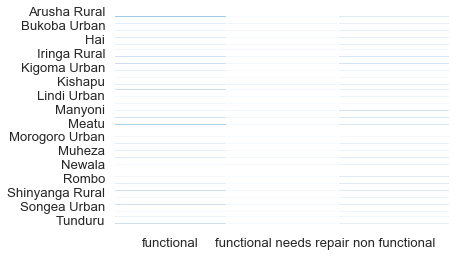

In [495]:
ct = pd.crosstab(df['lga'], df['status_group'],normalize = True)
sns.heatmap(ct, linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

### Population
#### ['population'] vs ['status_group']

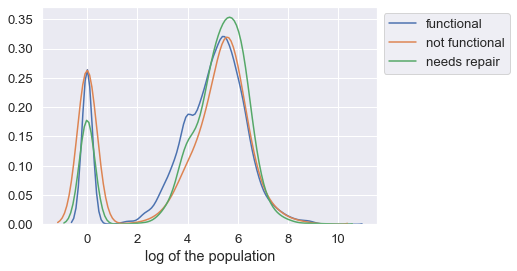

In [466]:
zero = df[df.population!=0]
sns.distplot(np.log(zero[zero.status_group == 'functional'].population), hist = False, 
            label='functional')
sns.distplot(np.log(zero[zero.status_group == 'non functional'].population), hist = False, 
            label = 'not functional')
sns.distplot(np.log(zero[zero.status_group == 'functional needs repair'].population), hist = False, 
            label = 'needs repair')

plt.xlabel('log of the population')
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

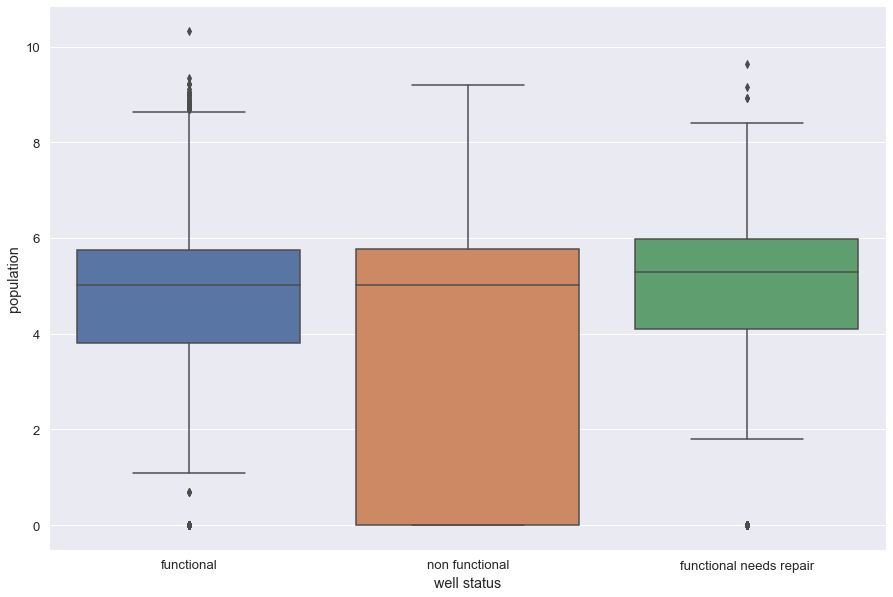

In [472]:
fig2 = plt.figure(figsize=(15,10))
sns.boxplot(x = zero.status_group, y = np.log(zero.population))
plt.xlabel('well status')
plt.show();

### Public Meeting 
#### ['public_meeting'] vs ['status_group']

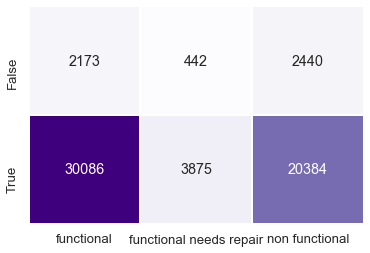

In [455]:
ct = pd.crosstab(df.public_meeting, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Purples')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Scheme Management / Scheme Name
#### ['scheme_managment']/['scheme_name'] vs ['status_group']

Scheme name doesn't seem particuarly relevant, so I will drop that. 

In [ ]:
colsdrop = colsdrop + ['scheme_name']

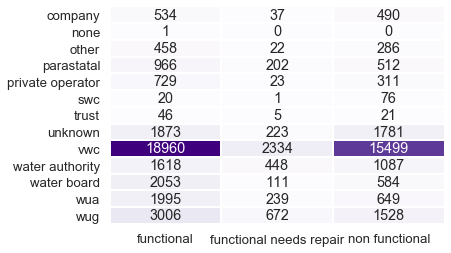

In [454]:
ct = pd.crosstab(df.scheme_management, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Purples')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Permit 
#### ['permit'] vs ['status_group']

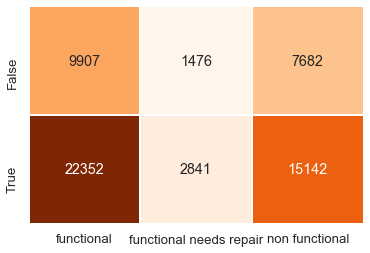

In [415]:
ct = pd.crosstab(df.permit, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Oranges')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [447]:
contingency_table = pd.crosstab(
    df.status_group,
    df.permit,
    margins = True)
contingency_table

permit,False,True,All
status_group,,,
functional,9907,22352,32259
functional needs repair,1476,2841,4317
non functional,7682,15142,22824
All,19065,40335,59400


In [451]:
f_obs = np.array([contingency_table.iloc[0][0:2].values,
                  contingency_table.iloc[1][0:2].values,
                 contingency_table.iloc[2][0:2].values])
f_obs

array([[ 9907, 22352],
       [ 1476,  2841],
       [ 7682, 15142]])

In [452]:
print(stats.chi2_contingency(f_obs)[0:3])

(62.62555267925711, 2.5178741702889013e-14, 2)


Chi Square test of independence shows there is significance. 

### Construction Year - Continuous
#### ['construction_year'] vs ['status_group']

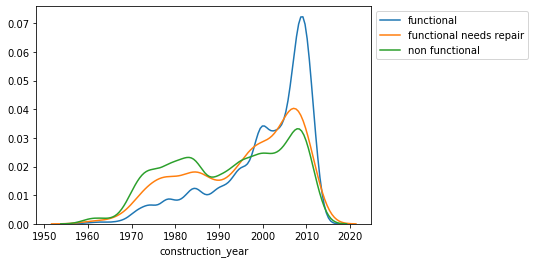

In [190]:
zeros = df[df.construction_year!=0]
sns.distplot(zeros[zeros['status_group'] == 'functional'].construction_year, hist = False, label = 'functional')
sns.distplot(zeros[zeros['status_group'] == 'functional needs repair'].construction_year, hist = False, label = 'functional needs repair')
sns.distplot(zeros[zeros['status_group'] == 'non functional'].construction_year, hist = False, label = 'non functional')

plt.legend(bbox_to_anchor = [1, 1])
plt.show()

Built in the last 60 years by decade.
Max year is 2013, Min year 1960, there are a lot of zero values, so we will bin the years from the 1960s to the 2010s. 
Other values will be listed as other. 

In [202]:
cond = [df.construction_year > 2010, 
       df.construction_year > 2000, 
       df.construction_year > 1990, 
       df.construction_year > 1980,
       df.construction_year > 1970,
       df.construction_year > 1960]
vals = ['10s','00s', '90s', '80s', '70s', '60s']
df['built_recent'] = np.select(cond, vals, 'others')

### Extraction Type / Extraction Type Group / Extraction Type Class
#### ['extraction_type']/['extraction_type_group']/['extraction_type_class'] vs ['status_group']

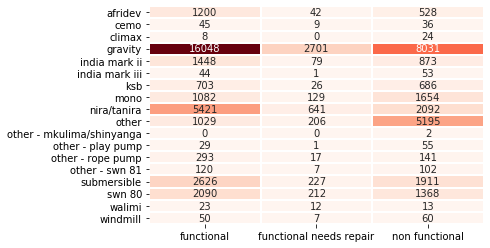

In [295]:
ct = pd.crosstab(df.extraction_type, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Reds')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [294]:
print('extraction_type_class:', len(df.extraction_type_class.unique()))
print('extraction_type_group:', len(df.extraction_type_group.unique()))
print('extraction_type:', len(df.extraction_type.unique()))

extraction_type_class: 7
extraction_type_group: 13
extraction_type: 18


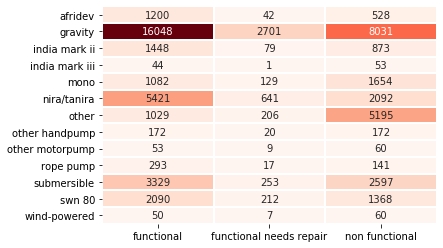

In [296]:
ct = pd.crosstab(df.extraction_type_group, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Reds')
plt.xlabel('')
plt.ylabel('')
plt.show()

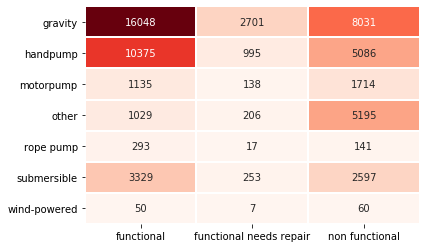

In [297]:
ct = pd.crosstab(df.extraction_type_class, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Reds')
plt.xlabel('')
plt.ylabel('')
plt.show()

It seems that extraction type is the most broken down. I don't believe one is more helpful than the other. 
The other argument is that extraction_type_class is simple, gets the job done and may be less complicated for our features when modeling, so we will keep that one for now. 
The chi squared test of independence does show it is significant with an alpha of 0.05, however, all three groups have the same statistical scores. 

extraction_type (7365.638497624808, 0.0, 36)

extraction_type_group (7265.845618207269, 0.0, 26)

extraction_type_class  (6931.201640539073, 0.0, 14)

In [ ]:
dropcols = dropcols + ['extraction_type', 'extraction_type_group']

In [392]:
contingency_table = pd.crosstab(
    df.status_group,
    df.extraction_type,
    margins = True)
len(contingency_table.columns)

19

In [393]:
f_obs = np.array([contingency_table.iloc[0][0:19].values,
                  contingency_table.iloc[1][0:19].values,
                 contingency_table.iloc[2][0:19].values])
f_obs

array([[ 1200,    45,     8, 16048,  1448,    44,   703,  1082,  5421,
         1029,     0,    29,   293,   120,  2626,  2090,    23,    50,
        32259],
       [   42,     9,     0,  2701,    79,     1,    26,   129,   641,
          206,     0,     1,    17,     7,   227,   212,    12,     7,
         4317],
       [  528,    36,    24,  8031,   873,    53,   686,  1654,  2092,
         5195,     2,    55,   141,   102,  1911,  1368,    13,    60,
        22824]])

In [404]:
from scipy import stats
print(stats.chi2_contingency(f_obs)[0:3])
print('with an alpha of 0.5 we can say there is a stastistical significance')

(7365.638497624808, 0.0, 36)
with an alpha of 0.5 we can say there is a stastistical significance


While there is significance, we cannot determine significance between the three subdivisions. 

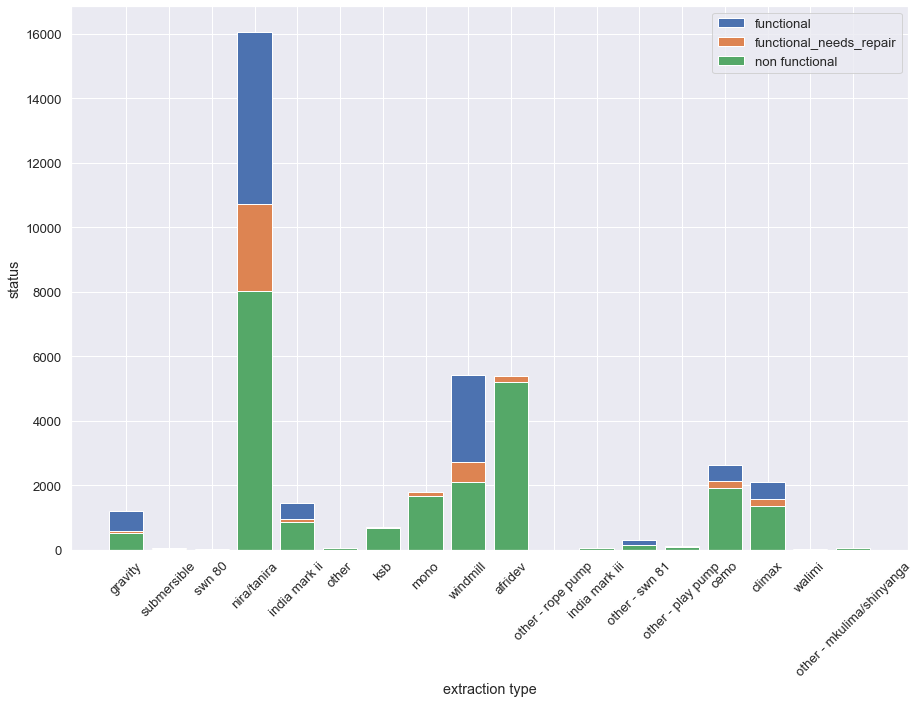

In [400]:
#Assigns the frequency values

#functional = contingency_table.iloc[0][0:18].values
functional_needs_repair = contingency_table.iloc[1][0:18].values
non_functional = contingency_table.iloc[2][0:18].values

#Plots the bar chart
fig = plt.figure(figsize=(15,10))
sns.set(font_scale=1.2)

categories = ['gravity',
 'submersible',
 'swn 80',
 'nira/tanira',
 'india mark ii',
 'other',
 'ksb',
 'mono',
 'windmill',
 'afridev',
 'other - rope pump',
 'india mark iii',
 'other - swn 81',
 'other - play pump',
 'cemo',
 'climax',
 'walimi',
 'other - mkulima/shinyanga']
    

p1 = plt.bar(categories, functional, 0.8)
p2 = plt.bar(categories, functional_needs_repair, 0.8, bottom = non_functional)
p3 = plt.bar(categories, non_functional, 0.8)
plt.xticks(rotation= 45)
plt.legend((p1[0], p2[0], p3[0]), ('functional','functional_needs_repair','non functional'))
plt.xlabel('extraction type')
plt.ylabel('status')
plt.show()

In [407]:
contingency_table = pd.crosstab(
    df.status_group,
    df.extraction_type_class,
    margins = True)
len(contingency_table.columns)

8

In [408]:
f_obs = np.array([contingency_table.iloc[0][0:19].values,
                  contingency_table.iloc[1][0:19].values,
                 contingency_table.iloc[2][0:19].values])
f_obs

array([[16048, 10375,  1135,  1029,   293,  3329,    50, 32259],
       [ 2701,   995,   138,   206,    17,   253,     7,  4317],
       [ 8031,  5086,  1714,  5195,   141,  2597,    60, 22824]])

In [409]:
print(stats.chi2_contingency(f_obs)[0:3])

(6931.201640539073, 0.0, 14)


### Management / Management Group
#### ['management']/['managment_group'] vs ['status_group']


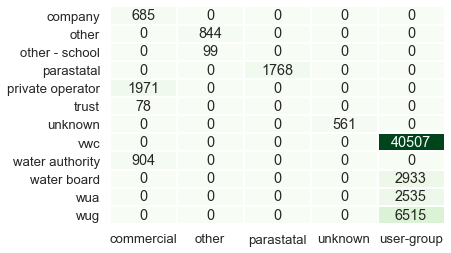

In [422]:
ct = pd.crosstab(df.management, df.management_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Greens')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [425]:
print('mangement_group: ', list(df.management_group.unique()))
print('management: ', list(df.management.unique()))

mangement_group:  ['user-group', 'other', 'commercial', 'parastatal', 'unknown']
management:  ['vwc', 'wug', 'other', 'private operator', 'water board', 'wua', 'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust']


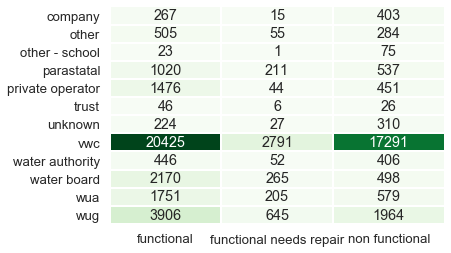

In [429]:
ct = pd.crosstab(df.management, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Greens')
plt.xlabel('')
plt.ylabel('')
plt.show()

Seems that the management subdivisions may prove helpful. I will drop managment_group. 

In [ ]:
colsdrop = colsdrop + ['management_group']

### Payment / Payment Type
#### ['payment']/['payment_type'] vs ['status_group']

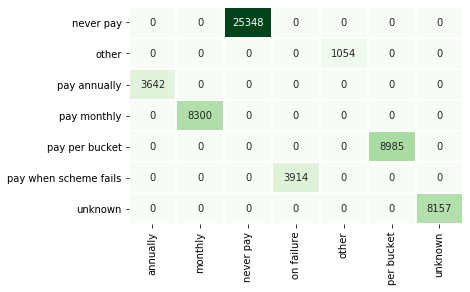

In [284]:
ct = pd.crosstab(df.payment, df.payment_type)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Greens')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [287]:
print('payment_type: ', list(df.payment_type.unique()))
print('payment: ', list(df.payment.unique()))

payment_type:  ['annually', 'never pay', 'per bucket', 'unknown', 'on failure', 'other', 'monthly']
payment:  ['pay annually', 'never pay', 'pay per bucket', 'unknown', 'pay when scheme fails', 'other', 'pay monthly']


This is a trick question. These are exactly the same with slightly different labels. 
payment_type is more concise, so I'll drop payment. 

In [ ]:
dropcols = dropcols + ['payment']

### Water Quality / Quality Group
#### ['water_quality']/['quality_group'] vs ['status_group']

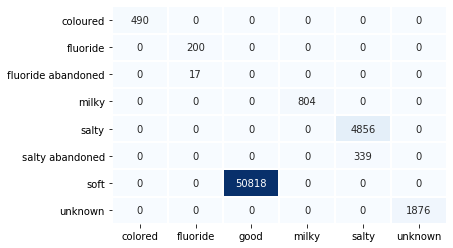

In [279]:
ct = pd.crosstab(df.water_quality, df.quality_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [273]:
print('water_quality: ', list(df.water_quality.unique()))
print('quality_group: ', list(df.quality_group.unique()))

water_quality:  ['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured', 'salty abandoned', 'fluoride abandoned']
quality_group:  ['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored']


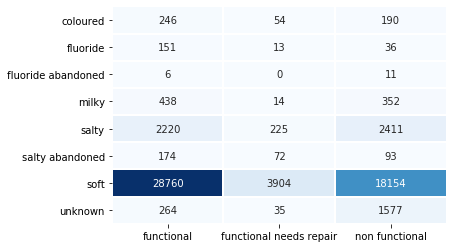

In [280]:
ct = pd.crosstab(df.water_quality, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()

It's a small differentation, but I'll keep the additional divides. 

In [282]:
dropcols = dropcols + ['quality_group']

### Quantity / Quantity Group
#### ['quantity']/['quantity_group'] vs ['status_group']

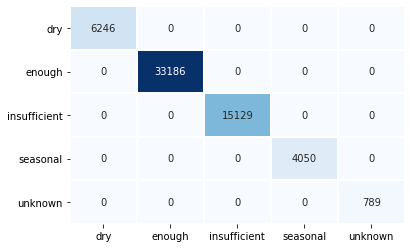

In [276]:
ct = pd.crosstab(df.quantity, df.quantity_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [251]:
df.quantity.unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

In [252]:
df.quantity_group.unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

These groups are identical, and we only need one. We aren't data hoarders, so we can drop the quanity group. 

In [ ]:
dropcols = dropcols + ['quantity_group']

### Source / Source Type / Source Class
#### ['source']/['source_type']/['source_class'] vs ['status_group']

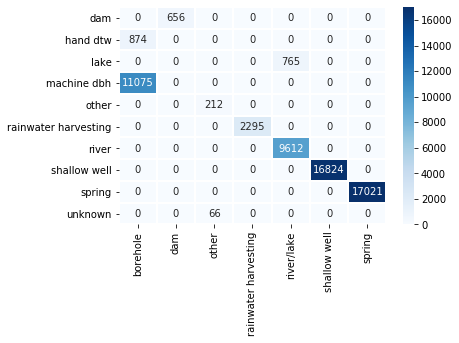

In [244]:
ct = pd.crosstab(df['source'], df['source_type'])
#cross tab allos me to pull just the two groups I'm looking at. 
#additional helpful paramaters are annot (annotated), the linewidths also allows some space. 
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths = 1, cbar = True, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

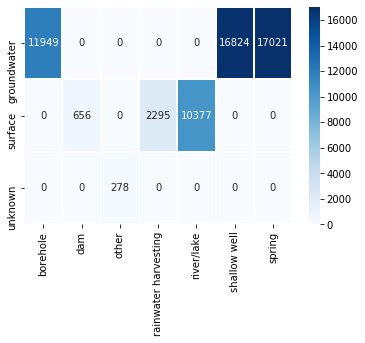

In [245]:
ct = pd.crosstab(df['source_class'], df['source_type'])
#cross tab allos me to pull just the two groups I'm looking at. 
#additional helpful paramaters are annot (annotated), the linewidths also allows some space. 
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths = 1, cbar = True, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

These groups do seem to be quite different. The source column seems to have the most varied classes. 
We can drop source_class and source_type. 

In [268]:
print('source_class: ', list(df.source_class.unique()))
print('source_type:', list(df.source_type.unique()))
print('source: ', list(df.source.unique()))

source_class:  ['groundwater', 'surface', 'unknown']
source_type: ['spring', 'rainwater harvesting', 'dam', 'borehole', 'other', 'shallow well', 'river/lake']
source:  ['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']


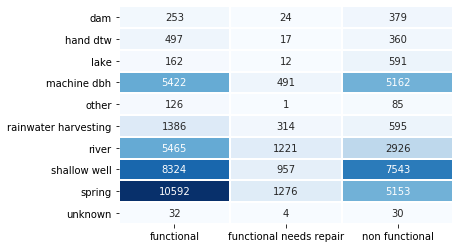

In [269]:
ct = pd.crosstab(df.source, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
dropcols = dropcols + ['source_class', 'source_type']

### Waterpoint Type / Waterpoint Type Group
#### ['waterpoint_type']/['waterpoint_type_group'] vs ['status_group']

Looking at the differneces between these two groups, the waterpoint_type further divides the communal standpipe. 
This sub-group may be beneficial when predicting. 

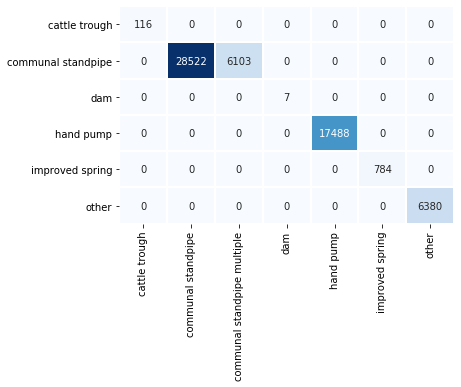

In [229]:
ct = pd.crosstab(df['waterpoint_type_group'], df['waterpoint_type'])
#cross tab allos me to pull just the two groups I'm looking at. 
#additional helpful paramaters are annot (annotated), the linewidths also allows some space. 
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths = 1, cbar = False, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [263]:
print('waterpoint type: ', list(df.waterpoint_type.unique()))
print('waterpoint type group: ', list(df.waterpoint_type_group.unique()))

waterpoint type:  ['communal standpipe', 'communal standpipe multiple', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']
waterpoint type group:  ['communal standpipe', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']


Above you can see the differences in the break down of the two features. Below we can see that the additional break down does have significance to our target variable. 


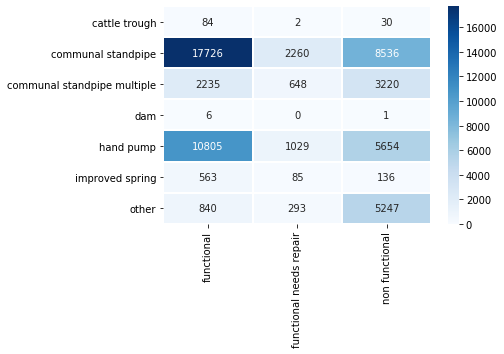

the breakdown between communal standpipe and communal standpipe multiple shows here where we can further break down that waterpoint


In [265]:
ct = pd.crosstab(df.waterpoint_type, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f',linewidths = 1, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()
print('the breakdown between communal standpipe and communal standpipe multiple shows here where we can further break down that waterpoint')

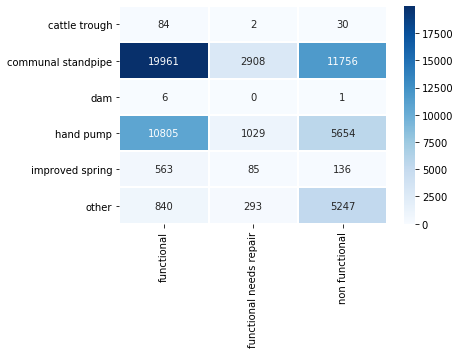

In [260]:
ct = pd.crosstab(df.waterpoint_type_group, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f',linewidths = 1, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
dropcols = dropcols + ['waterpoint_type_group']

In [48]:
df.to_pickle('eda_df.pkl')